In [ ]:
# 06a - Préparation répertoires pour Yolo v8
#   1) Segmente l'ensemble de données en créant des liens dans les 3 répertoires train, val et test
#   2) Crée un fichier texte par image avec la classe et les coordonnées de polygones (répertoire labels)

In [1]:
# Définitions globales
HOME = '/Users/u600141/OneDrive - La Francaise des Jeux/Data/constructions/'
PATHS_BDTOPO_PICKLE = HOME + 'images/BDTOPO/pickle/'
PATHS_BDORTHO_PICKLE = HOME + 'images/BDORTHO_RGB/pickle/'

PATHS_YOLO = HOME + 'images/yolo/'
PATHS_IMG_TRAIN = PATHS_YOLO + 'RGB/images/train/'
PATHS_IMG_VALID = PATHS_YOLO + 'RGB/images/val/'
PATHS_IMG_TEST = PATHS_YOLO + 'RGB/images/test/'
PATHS_LBL_TRAIN = PATHS_YOLO + 'RGB/labels/train/'
PATHS_LBL_VALID = PATHS_YOLO + 'RGB/labels/val/'
PATHS_LBL_TEST = PATHS_YOLO + 'RGB/labels/test/'

SEED = 123


In [2]:
# Imports

import pandas as pd
import geopandas as gpd
import shapely as sh
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split


In [3]:
# Chargement des méta-données BDTOPO
dft = pd.read_pickle(PATHS_BDTOPO_PICKLE + 'dft.pkl')
print (f'dft chargé, taille : {len(dft)}')

# Chargement des méta-données BDORTHO
dfi = pd.read_pickle(PATHS_BDORTHO_PICKLE + 'dfi.pkl')
print (f'dfi chargé, taille : {len(dfi)}')

dft chargé, taille : 694950
dfi chargé, taille : 11875


In [5]:
# dfi : contient les chemins vers les images et les coordonnées qui délimitent l'image
dfi.head()

,imgID,cutID,xrange,yrange,filename,bdortho_filename,mask_filename,NumberOfPolygons
0,0,0,"(645000.0, 645200.0)","(6859800.0, 6860000.0)",images/BDORTHO_RGB/1000x1000/00-000.jpg,/Users/u600141/OneDrive - La Francaise des Jeu...,images/BDORTHO_RGB/masks_1000x1000/mask-00-000...,113
1,0,1,"(645200.0, 645400.0)","(6859800.0, 6860000.0)",images/BDORTHO_RGB/1000x1000/00-001.jpg,/Users/u600141/OneDrive - La Francaise des Jeu...,images/BDORTHO_RGB/masks_1000x1000/mask-00-001...,16
2,0,2,"(645400.0, 645600.0)","(6859800.0, 6860000.0)",images/BDORTHO_RGB/1000x1000/00-002.jpg,/Users/u600141/OneDrive - La Francaise des Jeu...,images/BDORTHO_RGB/masks_1000x1000/mask-00-002...,26
3,0,3,"(645600.0, 645800.0)","(6859800.0, 6860000.0)",images/BDORTHO_RGB/1000x1000/00-003.jpg,/Users/u600141/OneDrive - La Francaise des Jeu...,images/BDORTHO_RGB/masks_1000x1000/mask-00-003...,81
4,0,4,"(645800.0, 646000.0)","(6859800.0, 6860000.0)",images/BDORTHO_RGB/1000x1000/00-004.jpg,/Users/u600141/OneDrive - La Francaise des Jeu...,images/BDORTHO_RGB/masks_1000x1000/mask-00-004...,37


In [7]:
# dft : contient l'ensemble des polygones "bâtiment" (on n'utilise que la colonne geometry)
dft['geometry'].head()

0    POLYGON Z ((650852.800 6855902.200 61.400, 650...
1    POLYGON Z ((650614.500 6856461.700 93.000, 650...
2    POLYGON Z ((650602.400 6856529.700 91.000, 650...
3    POLYGON Z ((650615.600 6856558.700 90.300, 650...
4    POLYGON Z ((650555.200 6856489.500 90.800, 650...
Name: geometry, dtype: geometry

In [4]:
# Séparation du jeu de données
# On garde 10% en validation finale (80% train et 20% test sur les 90% restant) 
df_test = dfi[(dfi.index % 10) == 0].reset_index()
df_train, df_valid = train_test_split(dfi[(dfi.index % 10) != 0], test_size=0.2, random_state=SEED)

print (f'Lignes df_train : {len(df_train)} ({len(df_train)/len(dfi)*100:.0f} %)')
print (f'Lignes df_valid : {len(df_valid)} ({len(df_valid)/len(dfi)*100:.0f} %)')
print (f'Lignes df_test  : {len(df_test)} ({len(df_test)/len(dfi)*100:.0f} %)')

Lignes df_train : 8549 (72 %)
Lignes df_valid : 2138 (18 %)
Lignes df_test  : 1188 (10 %)


In [8]:
# normalizePolygons() permet de mettre les coordonnées des polygones au format Yolo, à savoir :
#   - normalisées entre 0 et 1
#   - origine en haut à gauche (d'où reverseY)
#   - abs() est utilisée pour supprimer les erreurs d'arrondi négatif vers 0
def normalizePolygon(xy, xrange, yrange, reverseY=False):
    if (reverseY==True):
        ret = abs((xy - [xrange[0], yrange[1]]) * [1/(xrange[1]-xrange[0]), 1/(yrange[0]-yrange[1])])
    else:
        ret = abs((xy - [xrange[0], yrange[0]]) * [1/(xrange[1]-xrange[0]), 1/(yrange[1]-yrange[0])])
    return ret

# getIntersectingPolygons() : retourne l'intersection entre les polygones du dataframe et les bords de l'image
def getIntersectingPolygons(df, xrange, yrange, minArea=0, normalize=False, reverseY=False):
    rect_poly = sh.Polygon([(xrange[0], yrange[0]),
                            (xrange[1], yrange[0]),
                            (xrange[1], yrange[1]),
                            (xrange[0], yrange[1])])
    intersect = df['geometry'].values.intersection(rect_poly)
    intersect = intersect[~ intersect.is_empty]
    if (normalize==True):
        intersect = gpd.GeoSeries(sh.transform(intersect, lambda p : normalizePolygon(p, xrange, yrange, reverseY)))
    if (minArea > 0):
        intersect = intersect[intersect.area >= minArea]
    return intersect


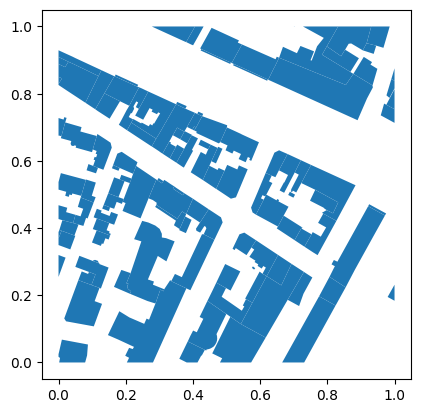

In [11]:
# Exemple de getIntersectingPolygons
i = getIntersectingPolygons(dft, (645000.0, 645200.0), (6859800.0, 6860000.0), normalize=True, reverseY=True)
i.plot()
plt.show();

In [15]:
# generateLabels() crée les labels pour Yolov8 (1 fichier texte par label)
def generateLabels(df_images, df_polygons, dest_path):
    polygons_count, multipolygons_count, ignored_count = 0, 0, 0
    for index, row in df_images.iterrows():
        # Intersection entre l'image et les polygones
        polygons = getIntersectingPolygons(df_polygons, row['xrange'], row['yrange'],
                                           minArea=0, normalize=True, reverseY=True)
        if len(polygons) > 0:
            labelpath = dest_path + row['filename'].split('/')[-1][:-4] + '.txt'
            # Transformation des multipolygones (créés par l'intersection) en polygones
            select_multi = (polygons.geom_type == 'MultiPolygon') | (polygons.geom_type == 'GeometryCollection')
            polygons_multi = polygons[select_multi]
            multipolygons_count += len(polygons_multi)
            polygons = polygons[~select_multi]
            for p in polygons_multi:
                polygons = pd.concat([polygons, gpd.GeoSeries(list(p.geoms))])
            # Création du fichier
            with open(labelpath, 'w') as f:
                for p in polygons.drop_duplicates():  # suppression des doublons (dûs à des polygones de même surface mais altitudes différentes)
                    if (p.geom_type == 'Polygon'):
                        p = sh.force_2d(p)
                        # le split sert à supprimer les trous dans les polygones
                        line = sh.wkt.dumps(p, rounding_precision=4)[10:-2].split(')')[0].replace(',', '')
                        polygons_count += 1
                        f.write('1 ' + line + '\n')
                    else:
                        ignored_count += 1
    print (f'polygons_count={polygons_count}, multipolygons_count={multipolygons_count}, ignored_count={ignored_count}')

In [16]:
# Test de generateLabels()
generateLabels(df_train[(df_train['imgID']==1) & (df_train['cutID']==563)], dft, PATHS_LBL_TRAIN)

polygons_count=98, multipolygons_count=3, ignored_count=0


In [15]:
# Génération de tous les labels
generateLabels(df_train, dft, PATHS_LBL_TRAIN)
generateLabels(df_valid, dft, PATHS_LBL_VALID)
generateLabels(df_test, dft, PATHS_LBL_TEST)
 

polygons_count :  65777 multipolygons_count :  640 ignored_count :  144


In [17]:
# removeDuplicates() repasse en revue les fichier pour supprimer les éventuels polygones doublons qui sont apparus
def removeDuplicates(path):
    unique_lines = []
    nb_duplicates = 0
    with open(path, 'r') as f:
        for line in f.readlines():
            if line in unique_lines:
                nb_duplicates +=1
            else:
                unique_lines.append(line)
    with open(path, 'w') as f:
        f.writelines(unique_lines)
    if (nb_duplicates > 0):
        print (f'Fichier {f} - Nombre de duplicats : {nb_duplicates})

import glob
for path in [PATHS_LBL_TRAIN, PATHS_LBL_VALID, PATHS_LBL_TEST]:
    files = glob.glob(path + '*.txt')
    for f in files:
        removeDuplicates(f)